In [2]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.gridspec import GridSpec
import seaborn as sns

import ssm
from ssm.util import random_rotation
from ssm.plots import plot_dynamics_2d
import scipy.io

In [4]:
temp_data = scipy.io.loadmat('primarymotorSpikesArthur1.mat')['ySpikes'].astype(int)
num_trials, num_bins, num_neurons = np.shape(temp_data)
spikes = [temp_data[ii_trial, :, :] for ii_trial in range(np.shape(temp_data)[0])]
print('Num trials: ', num_trials)

Num trials:  162


In [5]:
state_dim = 2
lds = ssm.LDS(num_neurons, state_dim, emissions="poisson_orthog", emission_kwargs=dict(link = 'softplus'))
elbos, q = lds.fit(spikes, method="laplace_em", num_iters=10) # EM fitting
state_means = q.mean_continuous_states # Get the posterior mean of the continuous states

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

In [6]:
# Smooth the data under the variational posterior ??? Need to ask Josh what that means 

smoothed_obs = np.zeros([num_trials, num_bins, num_neurons])

for ii_trial in range(num_trials):

    smoothed_obs[ii_trial, :, :] = lds.smooth(state_means[ii_trial], spikes[ii_trial])


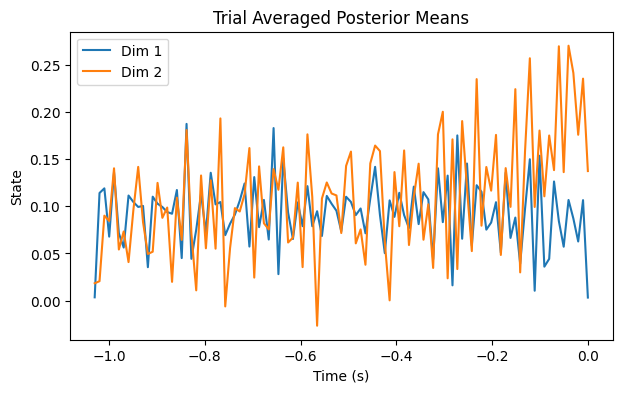

<Figure size 640x480 with 0 Axes>

In [7]:
state_means_array = np.zeros([num_trials, num_bins, state_dim])

for ii_trial in range(num_trials):

    state_means_array[ii_trial, :, :] = state_means[ii_trial]

# Get the mean for each of the dimensions

mean_state_means = np.mean(state_means_array, axis = 0)
bin_size = .01
time = bin_size * np.linspace(-num_bins, -bin_size, num_bins)
labels = [f'Dim {ii_dim + 1}' for ii_dim in range(state_dim)]

plt.figure(figsize = (7, 4))
lines = plt.plot(time, mean_state_means)
plt.xlabel('Time (s)')
plt.ylabel('State')
plt.title('Trial Averaged Posterior Means')
plt.legend(lines, labels)
plt.show()
plt.savefig('single_trial_latents/trial_averaged_posterior_means.png')

In [ ]:
# Plot a couple of the single trials on subplots

num_trials_plot = 20
num_plots = int(num_trials / num_trials_plot)

for ii_plot in range(num_plots):

    plt.figure(figsize = (16, 10))
    plt.suptitle('Single Trial Latent Trajectories')

    for jj_trial in range(num_trials_plot):

        plt.subplot(5, 4, jj_trial + 1)
        lines = plt.plot(time, state_means[jj_trial])
        plt.ylim([-2, 2])
        
        if jj_trial == 0:

            plt.legend(labels)
            plt.xlabel('Time (s)')
            plt.ylabel('State')

        else:

            plt.xticks([])
            plt.yticks([])

        plt.title(f'Seq {ii_plot * num_trials_plot + jj_trial + 1}')

    plt.savefig(f'single_trial_latents/single_trial_latents_{ii_plot}.png')
    plt.close()


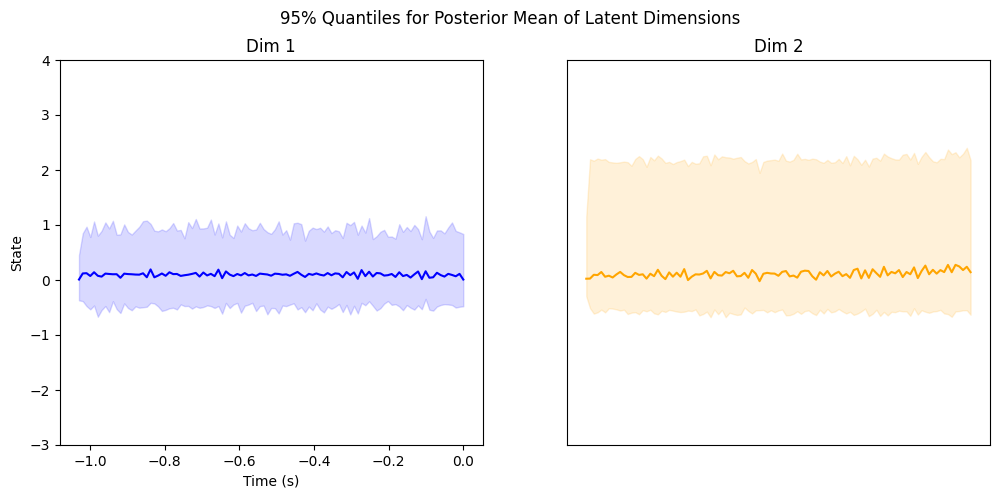

In [9]:
# Plot the 95% confidence bands for each of the latent dimensions

quantiles = [.025, .975]
conf_bands = {}
colors = ['blue', 'orange', 'green']

for ii_dim in range(state_dim):

    conf_bands[f'dim_{ii_dim + 1}'] = np.quantile(state_means_array[:, :, ii_dim], quantiles, axis = 0).T

plt.figure(figsize = (12, 5))
plt.suptitle('95% Quantiles for Posterior Mean of Latent Dimensions')

for ii_subplot in range(state_dim):

    plt.subplot(1, state_dim, ii_subplot + 1)
    plt.title(f'Dim {ii_subplot + 1}')
    plt.plot(time, mean_state_means[:, ii_subplot], color = colors[ii_subplot])
    plt.fill_between(time, conf_bands[f'dim_{ii_subplot + 1}'][:, 0], conf_bands[f'dim_{ii_subplot + 1}'][:, 1], 
        color = colors[ii_subplot], alpha = .15)
    plt.ylim([-3, 4])
    
    if ii_subplot == 0:
    
        plt.xlabel('Time (s)')
        plt.ylabel('State')

    else:

        plt.xticks([])
        plt.yticks([])

plt.savefig('single_trial_latents/quantiles_latent_dimensions.png')

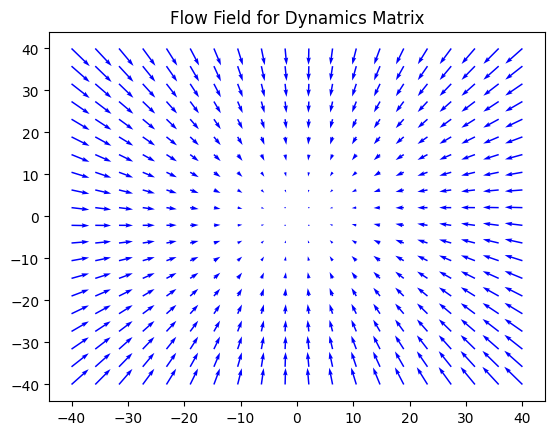

In [10]:
# Plot the dynamics vector field

q = plot_dynamics_2d(lds.dynamics.A, 
                     bias_vector= lds.dynamics.b,
                     color='blue')

plt.gca().set_title('Flow Field for Dynamics Matrix')
plt.savefig('dynamics_matrix_flow_field.png')

In [11]:
# Plot the reproduced average firing rates on top of the actual firing rates

state_to_param = np.copy(lds.emissions.Cs)[0]
state_to_param_bias = np.copy(lds.emissions.ds)
lambdas = np.zeros([num_trials, num_bins, num_neurons])

# Get Poisson rate parameters

for ii_trial in range(num_trials):

    for jj_bin in range(num_bins):

        lambdas[ii_trial, jj_bin, :] = np.log1p(np.exp(state_to_param @ state_means_array[ii_trial, jj_bin, :].reshape(state_dim, 1) + state_to_param_bias.T)).flatten()

# Sample the inhomogenous poisson process from the lambdas vector

pred_spikes = np.random.poisson(lam = lambdas)

# Sample many times to get averages per trial

num_samples = 1000
pred_spikes_samples = np.zeros([num_samples, num_trials, num_bins, num_neurons])

for ii_sample in range(num_samples):

    for jj_trial in range(num_trials):

        pred_spikes_samples[ii_sample, jj_trial] = np.random.poisson(lam = lambdas[jj_trial])

pred_spikes_averaged = np.mean(pred_spikes_samples, axis = 0)
print(np.shape(pred_spikes_averaged))

(162, 103, 160)


In [12]:
# Stack rasters on top of each other for all neurons, given trial

from matplotlib.gridspec import GridSpec
from scipy.stats import gaussian_kde

num_cols = 4
num_rows = 6

for ii_trial in range(num_trials):

    pred_spike_times = []
    real_spike_times = []

    for jj_neuron in range(num_neurons):

        pred_spike_times.append([bin_size * (kk_index - num_bins) for kk_index in range(num_bins) if pred_spikes[ii_trial][kk_index, jj_neuron] > 0])
        real_spike_times.append([bin_size * (kk_index - num_bins) for kk_index in range(num_bins) if spikes[ii_trial][kk_index, jj_neuron] > 0])

    fig = plt.figure(constrained_layout = True)
    gs = fig.add_gridspec(num_rows, num_cols)
    ax1 = fig.add_subplot(gs[0:3, 0:4])
    ax1.set_title(f'Simulated Raster for Seq {ii_trial + 1}', color = 'red', fontsize = 10)
    ax1.eventplot(real_spike_times, color = 'red')
    ax1.set_xticks([])
    ax1.set_xticklabels([])
    
    ax2 = fig.add_subplot(gs[3:, 0:4])
    ax2.eventplot(pred_spike_times, color = 'black')
    ax2.set_title(f'Real Raster for Seq {ii_trial + 1}', color = 'black', fontsize = 10)
    ax2.set_xlabel('Time (s)')
    ax2.set_ylabel('Neuron')

    plt.savefig(f'rasters/raster_{ii_trial + 1}.png')
    plt.close()


In [13]:
# Reproduce the firing rates for a given number of neurons per trial

from scipy.ndimage import gaussian_filter1d

num_rows = 5
num_cols = 5
num_subplots = num_rows * num_cols
time = np.linspace(-1 + bin_size, 0, num_bins)
neurons_to_plot = np.linspace(1, num_neurons - 1, num_subplots).astype(int)
sigma = 1.5

for ii_trial in range(num_trials):

    plt.figure(figsize = (12, 12))
    plt.suptitle('Average Predicted and Real Firing Rates')

    for jj_subplot, jj_neuron in enumerate(neurons_to_plot):

        plt.subplot(num_rows, num_cols, jj_subplot + 1)
        temp_pred = gaussian_filter1d(pred_spikes_averaged[ii_trial, :, jj_neuron] / bin_size, sigma)
        temp_real = gaussian_filter1d(spikes[ii_trial][:, jj_neuron] / bin_size, sigma)
        plt.plot(time, temp_pred, color = 'red', label = 'predicted')
        plt.plot(time, temp_real, color = 'black', label = 'real')
        plt.title(str(jj_neuron))
        plt.gca().set_xticks([])
        plt.gca().set_xticklabels([])
        plt.ylim(0, 30)

        if jj_subplot == 0:

            plt.xlabel('Time (s)')
            plt.ylabel('Firing Rate (Hz)')
            plt.title(f'Neuron {jj_neuron}')
            plt.legend()

        else:

            plt.gca().set_yticks([])
            plt.gca().set_yticklabels([])

    plt.savefig(f'rasters/firing_rates_{ii_trial + 1}')
    plt.close()

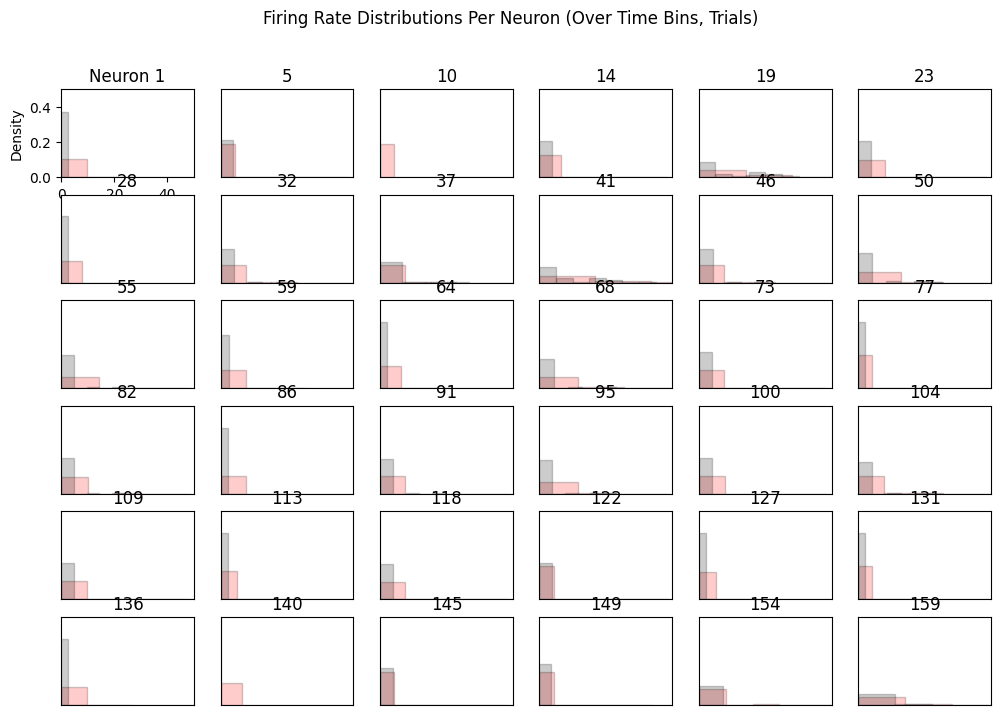

In [15]:
## Reproduce some firing rate histograms on same plot as real firing rate histogram 

# Per neuron

num_rows = 6
num_cols = 6
num_neurons_to_plot = num_rows * num_cols
neurons_to_plot = np.linspace(1, num_neurons - 1, num_neurons_to_plot).astype(int)

plt.figure(figsize = (12, 8))
plt.suptitle('Firing Rate Distributions Per Neuron (Over Time Bins, Trials)')

for ii_subplot, ii_neuron in enumerate(neurons_to_plot):

    temp_pred_firing_rates = np.ravel(gaussian_filter1d(pred_spikes_samples[:, :, :, ii_neuron] / bin_size, sigma, axis = 2))
    temp_real_firing_rates = np.ravel(gaussian_filter1d(temp_data[:, :, ii_neuron] / bin_size, sigma, axis = 1))

    plt.subplot(num_rows, num_cols, ii_subplot + 1)
    plt.hist(temp_pred_firing_rates, color = 'red', edgecolor = 'black', alpha = .2, label = 'Predicted', density = True)
    plt.hist(temp_real_firing_rates, color = 'black', edgecolor = 'black', alpha = .2, label = 'Real', density = True)
    plt.title(str(ii_neuron))
    plt.ylim(0, .5)
    plt.xlim(0, 50)

    if ii_subplot == 0:

        plt.title(f'Neuron {ii_neuron}')
        plt.xlabel('Firing Rate (Hz)')
        plt.ylabel('Density')

    else:

        plt.gca().set_yticks([])
        plt.gca().set_yticklabels([])
        plt.gca().set_xticks([])
        plt.gca().set_xticklabels([])

# Per trial



# Per interval, i.e. choose close to movement as your interval last 300 ms